In [136]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transiple
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import HGate, IGate
import numpy as np
import random

ImportError: cannot import name 'transiple' from 'qiskit' (/home/idbi/.local/share/virtualenvs/qiskit-byKeNw2z/lib/python3.7/site-packages/qiskit/__init__.py)

In [123]:
alice = QuantumRegister(4, name="alice")
bob = QuantumRegister(4, name="bob")
out = ClassicalRegister(4, name="out")

In [65]:
sim = Aer.get_backend("aer_simulator")

### Generate random basis

In [13]:
def generate_random_basis(circuit, qubits):
    gates = [HGate(), IGate()]
    for qubit in qubits:
        gate = random.choice(gates)
        circuit.append(gate, [qubit])
    return circuit

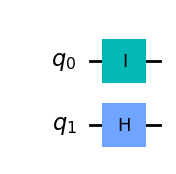

In [20]:
test_circuit = QuantumCircuit(2)
test_circuit = generate_random_basis(test_circuit, range(2))
test_circuit.draw("mpl")

### Generate Encoded Input from bit string

In [30]:
def generate_input_from_string(alice_circuit, bit_string):
    for qubit, bit in enumerate(bit_string[::-1]):
        if(bit == '1'):
            alice_circuit.x(qubit)
    return alice_circuit

### Alice Circuit

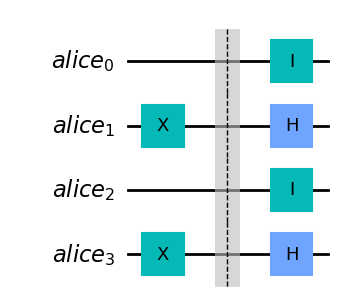

In [116]:
alice_circuit = QuantumCircuit(alice, name="alice")
alice_circuit = generate_input_from_string(alice_circuit, "1010")
alice_circuit.barrier()
alice_circuit = generate_random_basis(alice_circuit, alice)
alice_circuit.draw("mpl")

In [93]:
Statevector(alice_circuit).draw('latex')

<IPython.core.display.Latex object>

### Bob circuit

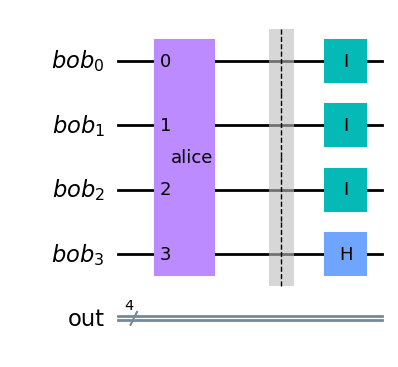

In [133]:
bob_circuit = QuantumCircuit(bob, out)
bob_circuit.append(alice_circuit, bob)
bob_circuit.barrier()
bob_circuit = generate_random_basis(bob_circuit, bob)
bob_circuit.draw("mpl")

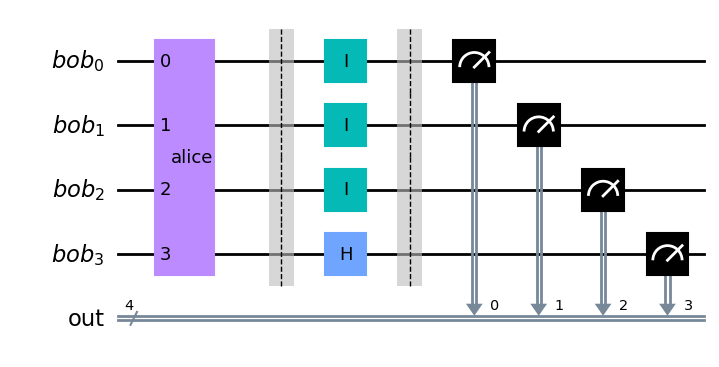

In [134]:
bob_circuit.barrier()
bob_circuit.measure(bob, out)
bob_circuit.draw("mpl")

In [139]:
sim.run(bob_circuit.decompose(), shots=1).result().get_counts()

{'1000': 1}